In [23]:
import Flux, Statistics
using Plots
using Statistics: mean, std, var
using Flux: gpu, Dense, relu, Chain, ADAM, RMSProp, params, throttle, mse, Tracker, @epochs

using BSON: @save, @load
using NNlib

# Model

In [193]:
# Dummy X data
N = 5000
sio2 = rand(N)
al2o3 = rand(N).*(1.0.-sio2)
na2o = rand(N).*(1.0.-sio2.-al2o3)
k2o = (1.0.-sio2.-al2o3.-na2o)
#tot = sio2.+al2o3.+k2o.+na2o
data = transpose([sio2 al2o3 na2o k2o])

scales_mean = mean(data,dims=2)
scales_std = std(data,dims=2)

data_sc = (data .- scales_mean)./(scales_std)

print("scaled mean and standard dev:\n")
print(mean(data_sc,dims=2))
print(std(data_sc,dims=2))

print("\n Scaler mean and std:\n")
print(scales_mean)
print("\n")
print(scales_std)

@save "./model/scaler_mean.bson" scales_mean
@save "./model/scaler_std.bson" scales_std

scaled mean and standard dev:
[1.98392e-15; 1.61955e-15; -1.44e-15; -2.3217e-15][1.0; 1.0; 1.0; 1.0]
 Scaler mean and std:
[0.495626; 0.251155; 0.128006; 0.125214]
[0.289539; 0.222657; 0.148329; 0.143051]

In [194]:
# The network : very simple autoencoder
N = 100 # Size of the encoding
encoder1 = Dense(4, N, relu , initb=ones)
encoder2 = Dense(N, N, relu , initb=ones)
encoder3 = Dense(N, N, relu , initb=ones)

decoder1 = Dense(N, 4, relu ,initb=ones)
decoder2 = Dense(N, N, relu ,initb=ones)
decoder3 = Dense(N, N, relu ,initb=ones)

dl1 = Chain(encoder1, decoder1)
dl2 = Chain(encoder1, encoder2, decoder2, decoder1)
dl3 = Chain(encoder1, encoder2, encoder3, decoder3, decoder2, decoder1)

model = Chain(encoder1,encoder2,encoder3)

loss1(X) = mse(dl1(X), X) # loss function
loss2(X) = mse(dl2(X), X) # loss function
loss3(X) = mse(dl3(X), X) # loss function

print("\n1 layer\n")
print(loss1(data_sc)) # this works
print("\n2 layers\n")
print(loss2(data_sc))
print("\n3 layers\n")
print(loss3(data_sc))


1 layer
3.8720400276627402 (tracked)
2 layers
11.377718377687398 (tracked)
3 layers
9.284194167785154 (tracked)

In [199]:
loss_1 = []
evalcb = () -> append!(loss_1,loss1(data_sc).data)
@epochs 50 Flux.train!(loss1, params(encoder1,decoder1), [(data_sc,)], ADAM(0.001),cb=evalcb)

loss_2 = []
evalcb = () -> append!(loss_2,loss2(data_sc).data)
@epochs 50 Flux.train!(loss2, params(encoder2,decoder2), [(data_sc,)], ADAM(0.001),cb=evalcb)

loss_3 = []
evalcb = () -> append!(loss_3,loss3(data_sc).data)
@epochs 50 Flux.train!(loss3, params(encoder3,decoder3), [(data_sc,)], ADAM(0.0001),cb=evalcb)

┌ Info: Epoch 1
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 2
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 3
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 4
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 5
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 6
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 7
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 8
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 9
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 10
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 11
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise

┌ Info: Epoch 41
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 42
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 43
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 44
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 45
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 46
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 47
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 48
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 49
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 50
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 1
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/

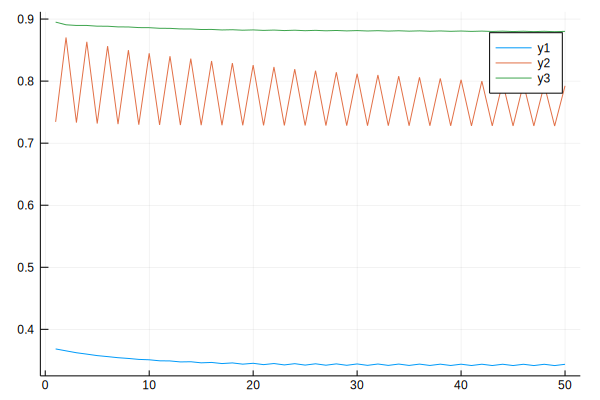

In [200]:
plot([loss_1,loss_2,loss_3])

In [201]:
scatter(data_sc',dl1(data_sc).data')

In [55]:
weights = Tracker.data.(params(model))
@save "./model/pretrained_w.bson" weights